# Imports

In [1]:
import os
import shutil
import pandas

from scattertools.support import molstat

# Variables

Variables to set the storage folder for the fit, the base name of the runfile, and the global optimizer. Further the
number of burn and production stepst for the MCMC are set. The run flag determines whether the refl1d MCMC is run, or
just a data analysis on a previous fit is performed.

Steps (and burn) are intentionally small in this example to reduce file sizes.

In [2]:
setupdir = os.getcwd()
store = "fit"
runfile = "run"
fitsource = "refl1d"

run = True
resume = False
burn = 1000
steps = 200

# Example Fit

The content of the following cell is written out to the runfile of the fit 'tblm.py'.

In [3]:
%%writefile run.py
# === Import section ===
import numpy as np
from molgroups import mol
from refl1d.names import load4, Parameter, SLD, Slab, Experiment, FitProblem
from refl1d.flayer import FunctionalProfile

CONTROLPOINTS = 8
SPACING = 15.0
dDp = [0.0] * CONTROLPOINTS
dVf = [0.0] * CONTROLPOINTS


# === Film structure definition section ===
protein = mol.Hermite()
protein.numberofcontrolpoints = CONTROLPOINTS

# molecular layer profile definition function
# traditionally called bilayer, although there is no bilayer in this example
def canvas(z, sigma, rho_bulk, rho_substrate, rho_protein, rho_protein_exchanged, protexchratio, nf_protein, penetration, dDp, dVf):
    # Set unused parameters

    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    rho_bulk *= 1e-6
    rho_substrate *= 1e-6
    rho_protein *= 1e-6
    rho_protein_exchanged *= 1e-6

    # protein start position on canvas
    substrate.fnSet(nSL=rho_substrate*substrate.vol, sigma=sigma, position=0)
    startz = substrate.z + 0.5 * substrate.length
    rho_protein_mod = (6.4e-6 - rho_bulk) / 7.0e-6 * rho_protein + (rho_bulk + 0.6e-6) / 7.0e-6 * rho_protein_exchanged
    rho_protein_mod = (rho_protein_mod - rho_protein) * protexchratio + rho_protein
    protein.fnSetRelative(SPACING, startz+penetration, dDp, dVf, rho_protein_mod, nf_protein)

    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = substrate.fnWriteProfile(z)

    protein.fnSetNormarea(normarea)
    area, nsl = protein.fnOverlayProfile(z, area, nsl, normarea)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * rho_bulk

    # === Export objects for post analysis ===
    dict1 = substrate.fnWriteGroup2Dict({}, 'substrate', np.arange(dimension) * stepsize)
    dict2 = protein.fnWriteGroup2Dict({}, 'protein', np.arange(dimension) * stepsize)
    problem.moldat = {**dict1, **dict2}
    dict3 = substrate.fnWriteResults2Dict({}, 'substrate')
    dict4 = protein.fnWriteResults2Dict({}, 'protein')
    problem.results = {**dict3, **dict4}

    # Return nSLD profile in Refl1D units
    return nsld*1e6


# Define molecule parameters
nf_protein = 1
protexchratio = 0.8
rho_protein = 1.8
rho_protein_exchanged = 3.4
h2o_roughness = Parameter(name='h2o_roughnes', value=2.5).range(2., 4.)
penetration = Parameter(name='penetration', value=0.0).range(-15.0, 10.0)
nf_protein_h2o = Parameter(name='nf_protein_h2o', value=1.0).range(0.8, 1.0)


for i in range(len(dDp)):
    dDp[i] = Parameter(name='dDp'+str(i), value=0.0).range(-1 * SPACING / 3., SPACING / 3.)
for i in range(1, len(dVf)-1):
    dVf[i] = Parameter(name='dVf'+str(i), value=0.001).range(-0.001, 0.95)
# first and last controlpoint is at zero volume fraction
dVf[0] = dVf[-1] = 0.0

# Define molecule object
substrate = mol.Box2Err(dz=0, dsigma1=0, dsigma2=2, dlength=40, dvolume=4000, dnSL=0, dnumberfraction=1, name='air')

# Define molgroups space.
dimension = 300       # Number of steps
stepsize = 0.5        # Length of steps

# === Stack ===
#
# First, we create a 'material' for each bulk layer, which has a real and imaginary
# scattering length density, stored in a Refl1d object called 'SLD'
air = SLD(name='air', rho=0.00, irho=0.00)
d2o = SLD(name='d2o', rho=6.4, irho=0.00)
h2o = SLD(name='h2o', rho=-0.56, irho=0.00)

# Then bulk layers are created, each with its own 'material'.  If you want to force
# two layers to always match SLD you can use the same material in multiple layers.
# The roughnesses of each layer are set to zero to begin with:

layer_air = Slab(material=air, thickness=0.0000, interface=2.0000)
layer_d2o = Slab(material=d2o, thickness=0.0000, interface=2.0000)
layer_h2o = Slab(material=h2o, thickness=0.0000, interface=2.0000)

# Use the canvas definition function to generate the bilayer SLD profile, passing in the relevant parameters.
# Note that substrate and bulk SLDs are linked to their respective materials.
mollayer0 = FunctionalProfile(dimension*stepsize,
                              0,
                              profile=canvas,
                              sigma=h2o_roughness,
                              rho_bulk=d2o.rho,
                              rho_substrate=air.rho,
                              rho_protein=rho_protein,
                              rho_protein_exchanged = rho_protein_exchanged,
                              protexchratio = protexchratio,
                              nf_protein=nf_protein,
                              penetration=penetration,
                              dDp=dDp,
                              dVf=dVf
                              )

mollayer1 = FunctionalProfile(dimension*stepsize,
                              0,
                              profile=canvas,
                              sigma=h2o_roughness,
                              rho_bulk=h2o.rho,
                              rho_substrate=air.rho,
                              rho_protein=rho_protein,
                              rho_protein_exchanged = rho_protein_exchanged,
                              protexchratio=protexchratio,
                              nf_protein=nf_protein_h2o,
                              penetration=penetration,
                              dDp=dDp,
                              dVf=dVf
                              )

# Stack the layers into individual samples, using common layer objects for layers that are unchanged between samples
# As a convention, always build the sample from the substrate up. If the neutron beam is incident from the substrate
# side, set back_reflectivity = True in the probe definition later.

sample0 = layer_air | mollayer0 | layer_d2o
sample1 = layer_air | mollayer1 | layer_h2o

# Set sample parameter ranges and constraints between layer properties

# nSLD parameters
d2o.rho.range(5.0, 6.4)
h2o.rho.range(-0.56, 0.5)
# h2o.irho.range(0.0, 2.0)

# layer thickness parameters
# layer_siox.thickness.range(20, 80)

# layer roughness parameters
###################################################################
# the 'interface' associated with layer0 is the boundary between #
# layer0 and layer1, and similarly for layer(N) and layer(N+1)   #
###################################################################
# layer_siox.interface.range(2.0000, 3.000)

# Si and SiOx roughnesses are the same
# layer_silicon.interface = layer_siox.interface

# === Data files ===
probe0 = load4('data0.txt', back_reflectivity=True)
probe1 = load4('data1.txt', back_reflectivity=True)

# Set instrumental (probe) parameters
probe0.background.range(-1e-9, 1e-6)
probe0.intensity.range(0.8, 1.2)
probe0.theta_offset.range(-0.015, 0.005)
probe1.background.range(-1e-9, 1e-5)
probe1.intensity = probe0.intensity
probe1.theta_offset = probe0.theta_offset
# probe.sample_broadening.range(-0.005, 0.02)
# probeh.sample_broadening = probe.sample_broadening

# Define critical edge oversampling for samples that require it
probe0.critical_edge(substrate=air, surface=d2o)
probe1.critical_edge(substrate=air, surface=h2o)

# === Problem definition ===
# a model object consists of a sample and a probe.

# step = True corresponds to a calculation of the reflectivity from an actual profile
# with microslabbed interfaces.  When step = False, the Nevot-Croce
# approximation is used to account for roughness.  This approximation speeds up
# the calculation tremendously, and is reasonably accuarate as long as the
# roughness is much less than the layer thickness
step = True

model0 = Experiment(sample=sample0, probe=probe0, dz=stepsize, step_interfaces = step)
model1 = Experiment(sample=sample1, probe=probe1, dz=stepsize, step_interfaces = step)

problem = FitProblem([model0, model1])

Overwriting run.py


# Running the fit

The following runs the fit using rs.py. It can also be run manually from the command line using, for example:
> refl1d_cli.py tblm.py --fit=dream --init=lhs --parallel --store=fit --burn=100 --steps=100

No file: /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/refl1d/noBLM_hermite_neutron/fit/run.py
No state to reload.
# steps: 200, # draws: 44000
step 1 cost 55.226(64)
                        background data0 .........| 9.97873e-07 in (-1e-09,1e-06)
                         intensity data0 |.........   0.804147 in (0.8,1.2)
                                    dDp0 .|........   -3.48333 in (-5,5)
                                    dDp1 .........|    4.17984 in (-5,5)
                                    dDp2 ....|.....  -0.354787 in (-5,5)
                                    dDp3 .........|    4.55303 in (-5,5)
                                    dDp4 .|........   -3.40557 in (-5,5)
                                    dDp5 ..|.......   -2.01589 in (-5,5)
                                    dDp6 |.........   -4.38483 in (-5,5)
                                    dDp7 ......|...    1.91139 in (-5,5)
                            

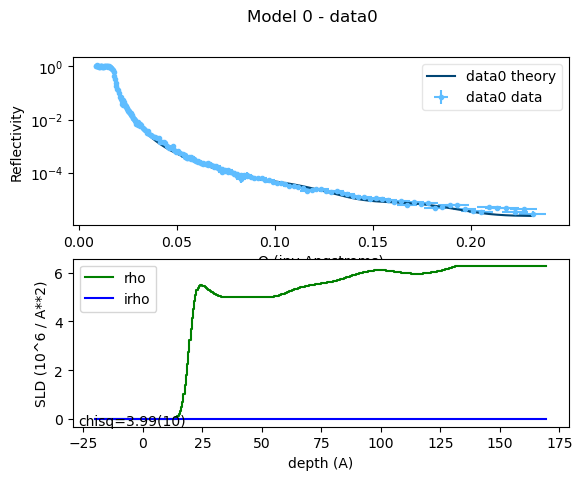

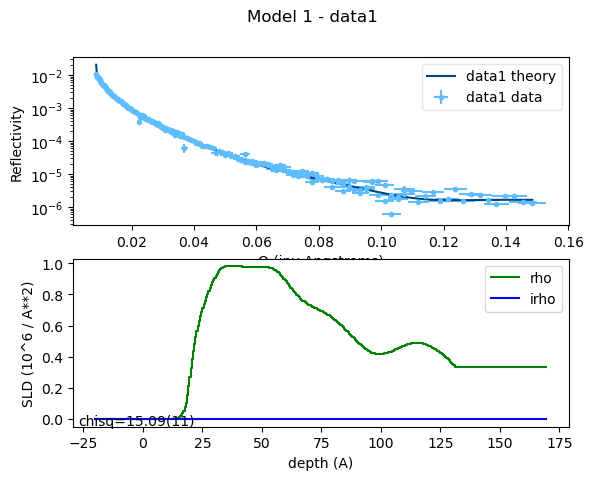

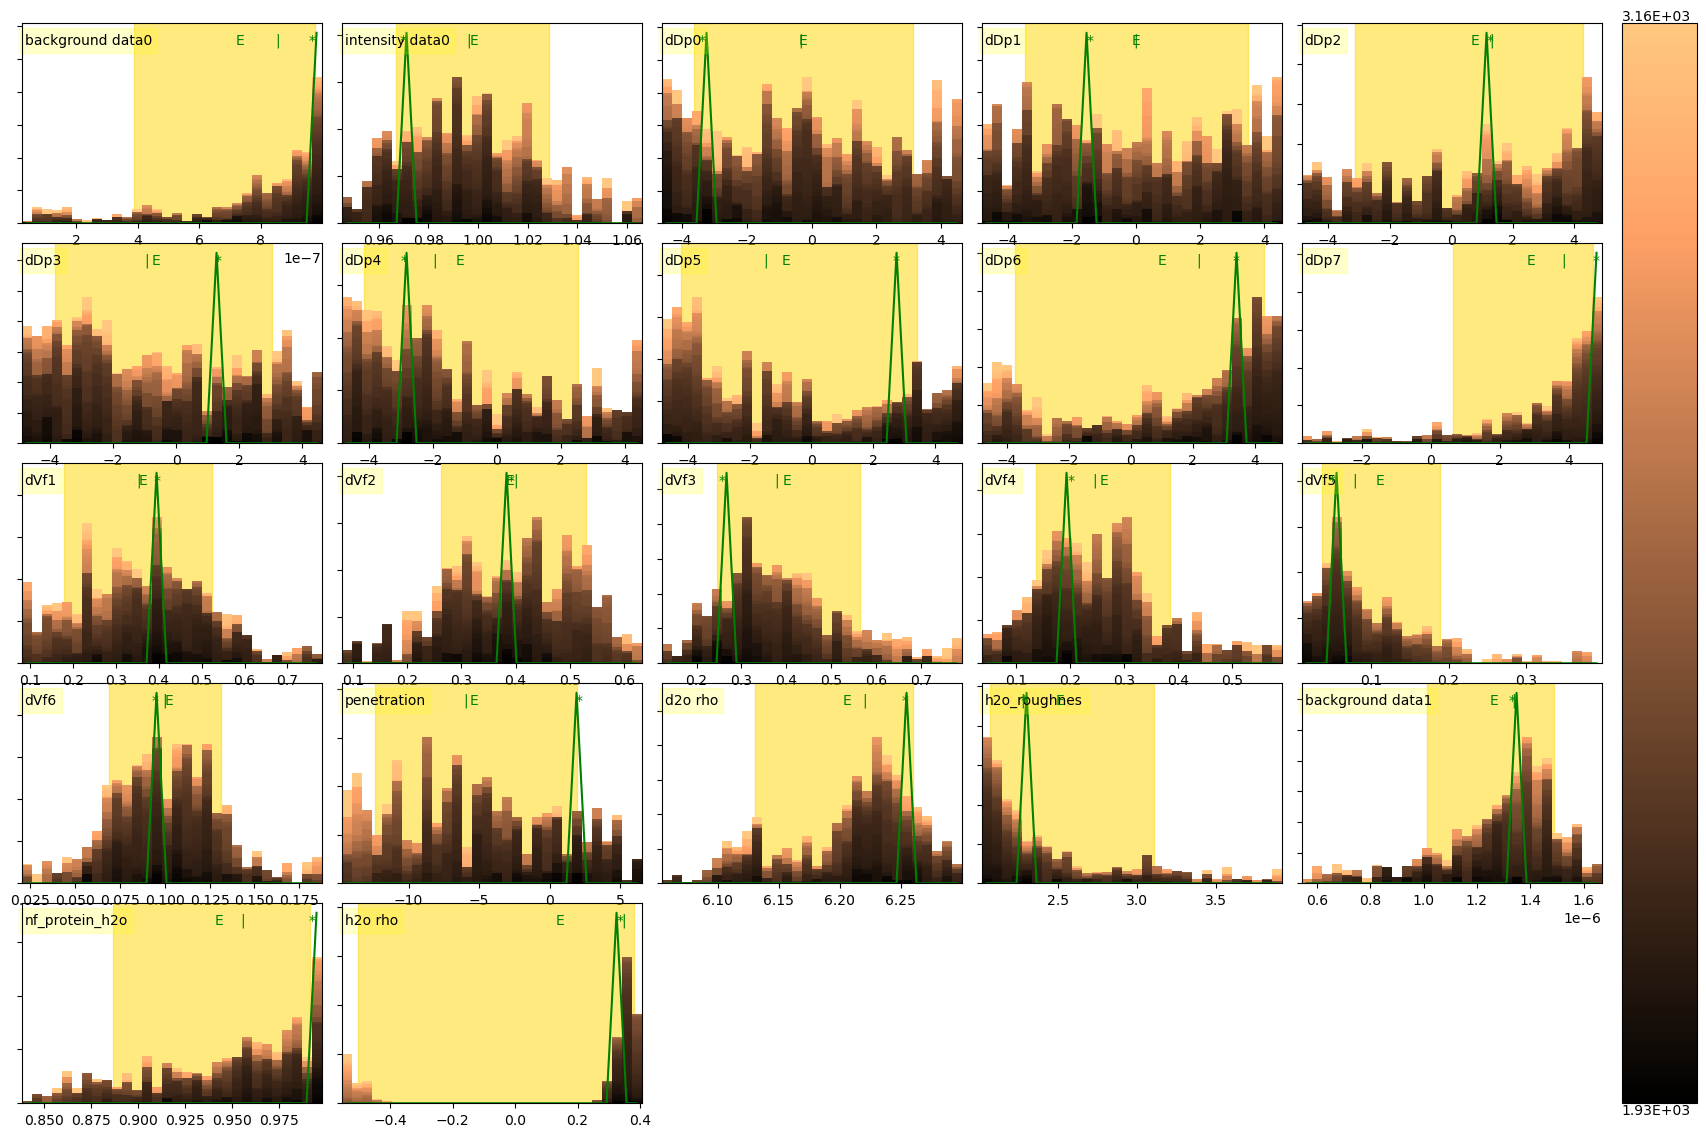

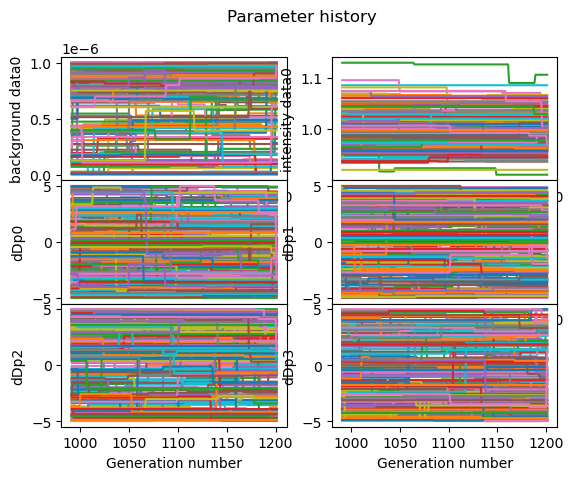

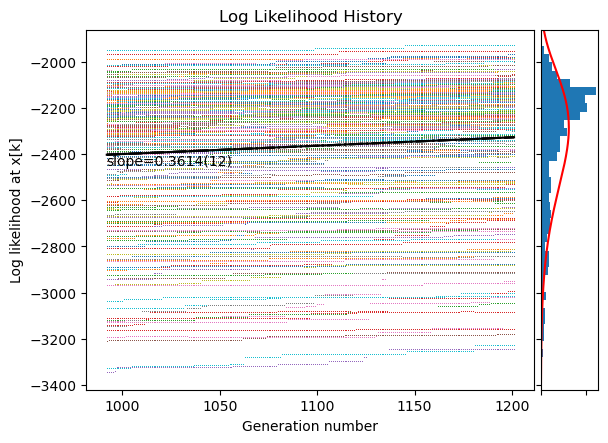

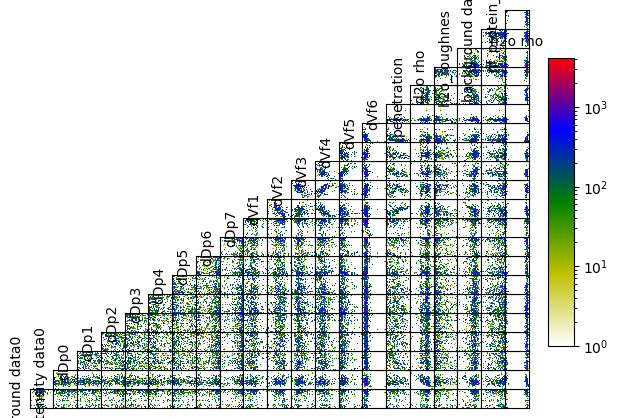

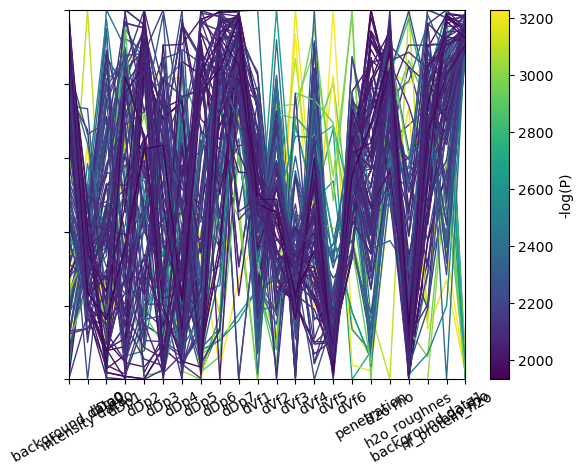

In [4]:
if run and not resume:
    if os.path.isdir(store):
        shutil.rmtree(store)
    os.mkdir(store)

fit_object = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None
)

if run:
    fit_object.Interactor.fnRunMCMC(burn, steps, batch=False, resume=resume)

print('Restore fit from: ', os.path.join(os.getcwd(), store, runfile))
fit_object.fnRestoreFit()

# Analysis

Statistical analysis of fit results.

Median values, 68% confidence limits (-1, 94%: -2, etc.), and fit intervals for all fit parameters.

In [5]:
sparse = 0.05
fit_object.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)

No StatDataPython.dat.
Recreate statistical data from sErr.dat.
Analysis of MCMC fit ...
Number of iterations: 2296

Fit Parameters:


,origin,name,vis,lower limit,upper limit,lower percentile,median percentile,upper percentile,interval lower,interval upper,confidence
0,fit,background_data0,[ | -|],-1.000000e-09,0.000001,3.939328e-07,8.538713e-07,9.721628e-07,-4.599385e-07,1.182915e-07,0.682689
1,fit,intensity_data0,[ |-| ],8.000000e-01,1.200000,9.674254e-01,9.975934e-01,1.029832e+00,-3.016806e-02,3.223817e-02,0.682689
2,fit,dDp0,[ | - | ],-5.000000e+00,5.000000,-3.611382e+00,-2.933068e-01,3.123297e+00,-3.318075e+00,3.416604e+00,0.682689
3,fit,dDp1,[ | - | ],-5.000000e+00,5.000000,-3.434218e+00,-1.056304e-01,3.356806e+00,-3.328587e+00,3.462437e+00,0.682689
4,fit,dDp2,[ | - | ],-5.000000e+00,5.000000,-3.075932e+00,1.203449e+00,4.277909e+00,-4.279382e+00,3.074460e+00,0.682689
5,fit,dDp3,[ | - | ],-5.000000e+00,5.000000,-3.922723e+00,-1.044961e+00,2.882115e+00,-2.877762e+00,3.927076e+00,0.682689
6,fit,dDp4,[ | - | ],-5.000000e+00,5.000000,-4.076106e+00,-1.849394e+00,2.510148e+00,-2.226711e+00,4.359542e+00,0.682689
7,fit,dDp5,[ | - | ],-5.000000e+00,5.000000,-4.214251e+00,-1.489087e+00,3.369177e+00,-2.725164e+00,4.858264e+00,0.682689
8,fit,dDp6,[ | -| ],-5.000000e+00,5.000000,-3.514755e+00,2.596510e+00,4.357852e+00,-6.111264e+00,1.761342e+00,0.682689
9,fit,dDp7,[ | -|],-5.000000e+00,5.000000,8.623328e-01,3.818284e+00,4.711593e+00,-2.955951e+00,8.933089e-01,0.682689


In [6]:
pandas.DataFrame(fit_object.diStatResults['Molgroups'].keys(), columns=['molecular groups'])

,molecular groups
0,substrate
1,protein


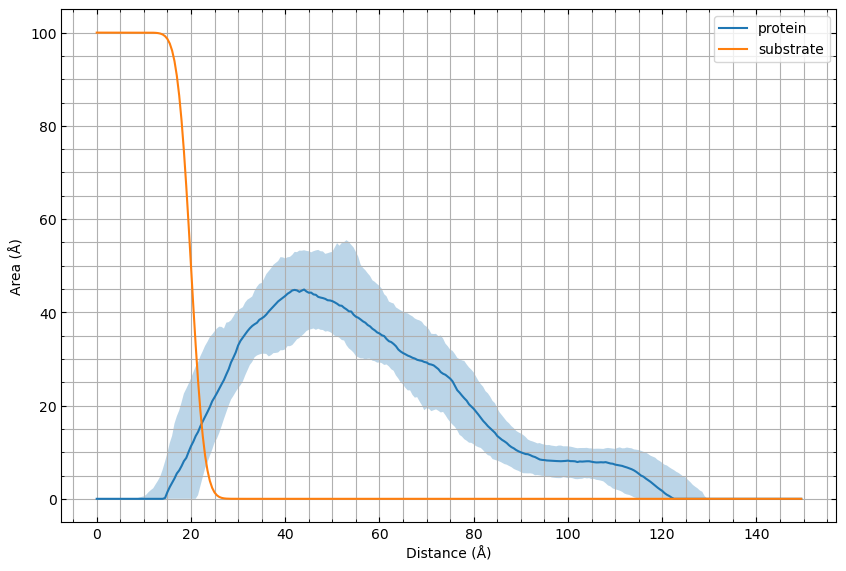

In [7]:
import matplotlib.pyplot as plt

median=['protein', 'substrate']
uncertainties=['protein']

fig, ax = plt.subplots()
for gp in median:
    zaxis = fit_object.diStatResults['Molgroups'][gp]['zaxis']
    area = fit_object.diStatResults['Molgroups'][gp]['median area']
    ax.plot(zaxis, area, label=gp)
    if gp in uncertainties:
        msigma = fit_object.diStatResults['Molgroups'][gp]['msigma area']
        psigma = fit_object.diStatResults['Molgroups'][gp]['psigma area']
        ax.fill_between(zaxis, msigma, psigma, alpha=0.3)

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("Area (Å)")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
#plt.xlim(0, 100)
#plt.xticks(numpy.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(10, 6.66)
plt.savefig(store + "/cvo", facecolor="white")
plt.show()

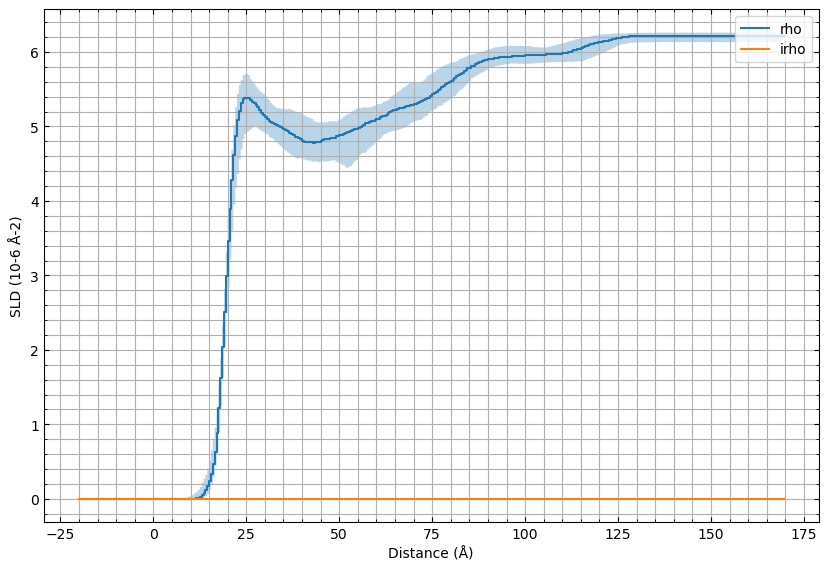

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
zaxis = fit_object.diStatResults['SLD']['z']

median = fit_object.diStatResults['SLD']['median rho']
ax.plot(zaxis, median, label='rho')
msigma = fit_object.diStatResults['SLD']['msigma rho']
psigma = fit_object.diStatResults['SLD']['psigma rho']
ax.fill_between(zaxis, msigma, psigma, alpha=0.3)

median = fit_object.diStatResults['SLD']['median irho']
ax.plot(zaxis, median, label='irho')
msigma = fit_object.diStatResults['SLD']['msigma irho']
psigma = fit_object.diStatResults['SLD']['psigma irho']
ax.fill_between(zaxis, msigma, psigma, alpha=0.3)

ax.legend(loc="upper right")
plt.xlabel("Distance (Å)")
plt.ylabel("SLD (10-6 Å-2)")
ax.minorticks_on()
ax.tick_params(which="both", direction="in", labelsize=10)
ax.tick_params(bottom=True, top=True, left=True, right=True, which="both")
#plt.xlim(0, 100)
#plt.xticks(numpy.arange(-35, 36, 5.0))
plt.grid(True, which='Both')
fig.patch.set_facecolor('white')
ax.figure.set_size_inches(10, 6.66)
plt.savefig(store + "/sld", facecolor="white")
plt.show()

A simple way to show output files from the fit. Publication-ready graphs can be created from the data in the storage
directory or using fit_object:

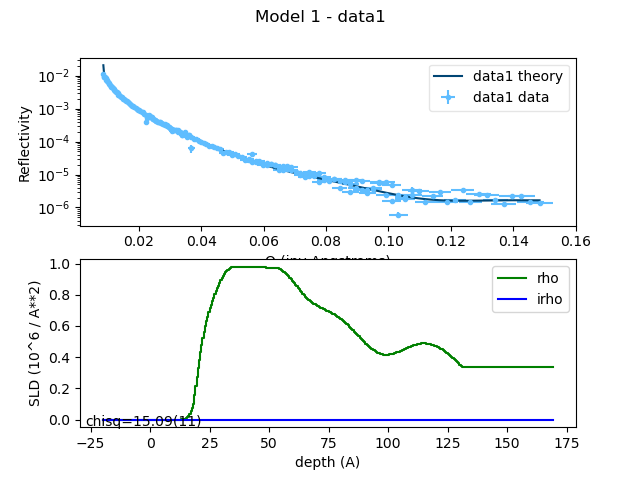

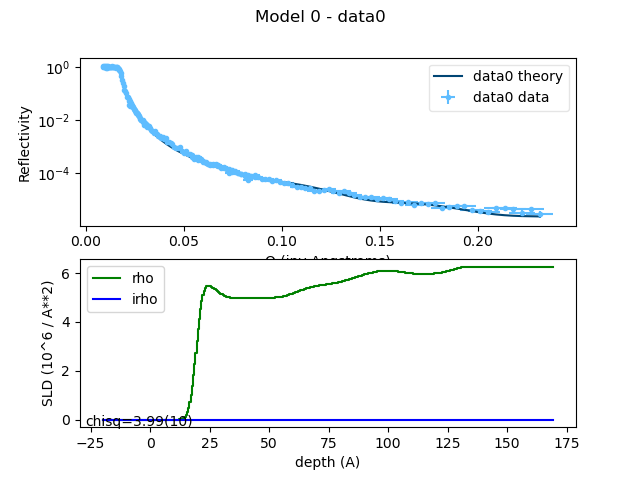

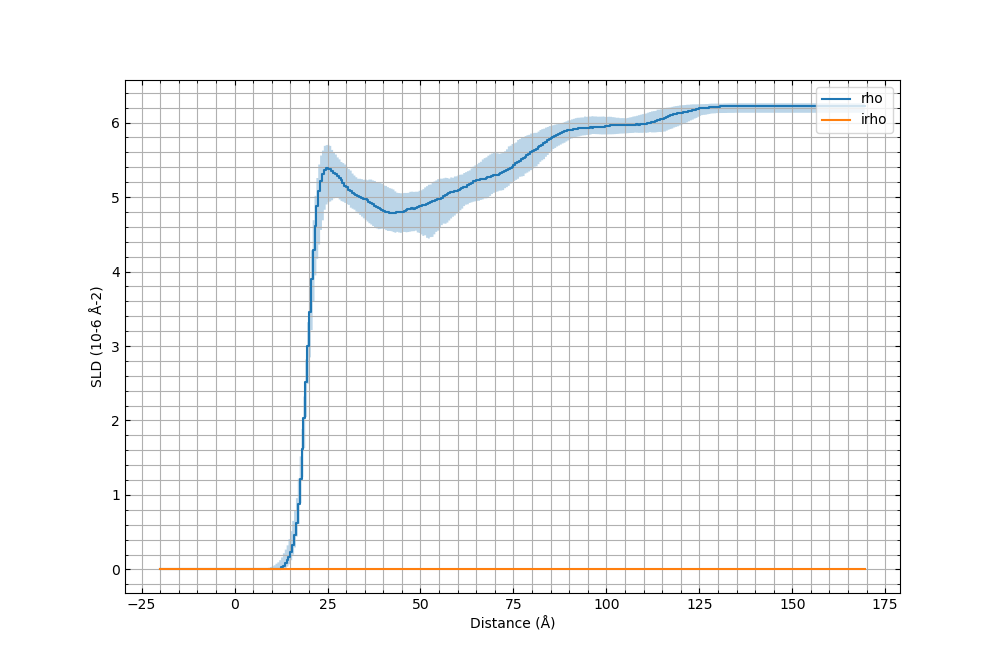

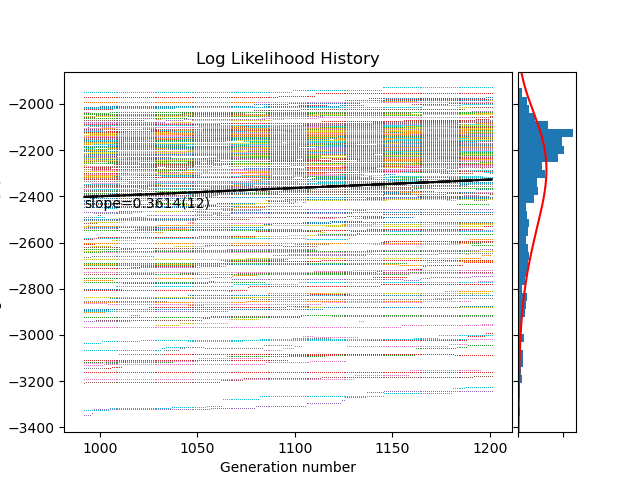

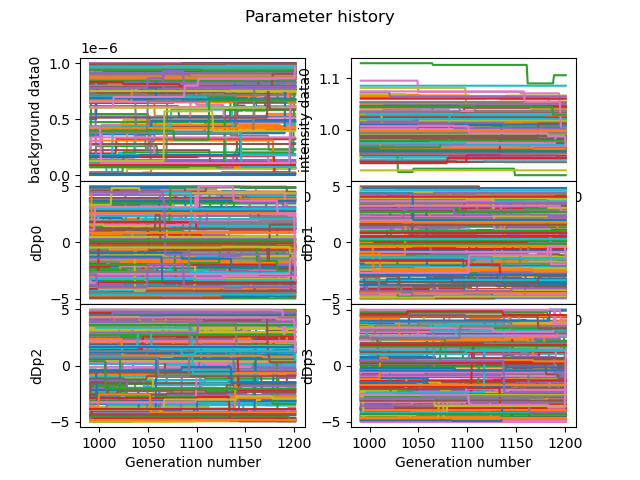

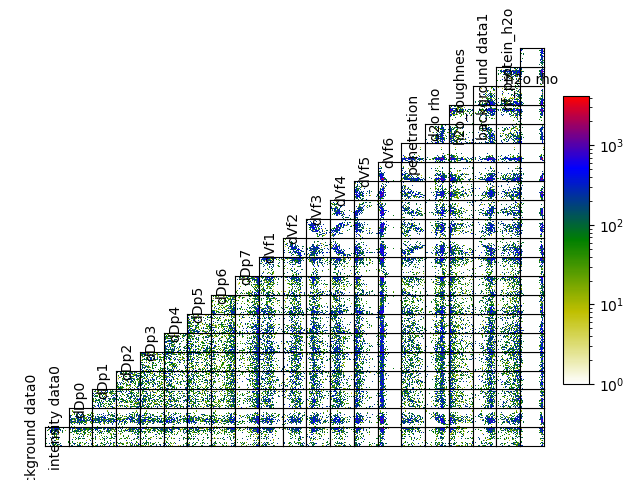

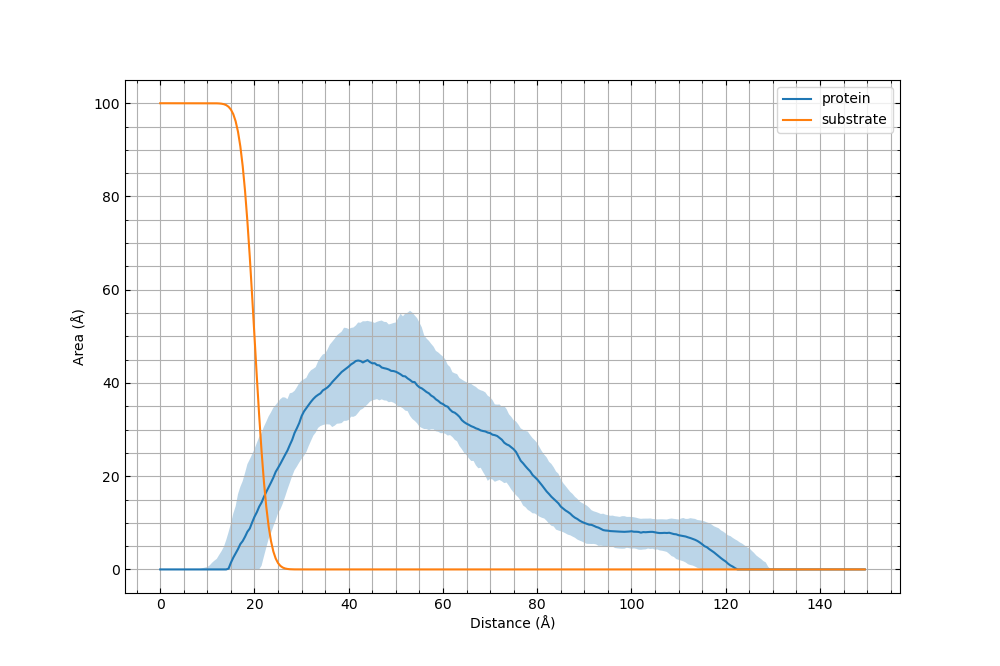

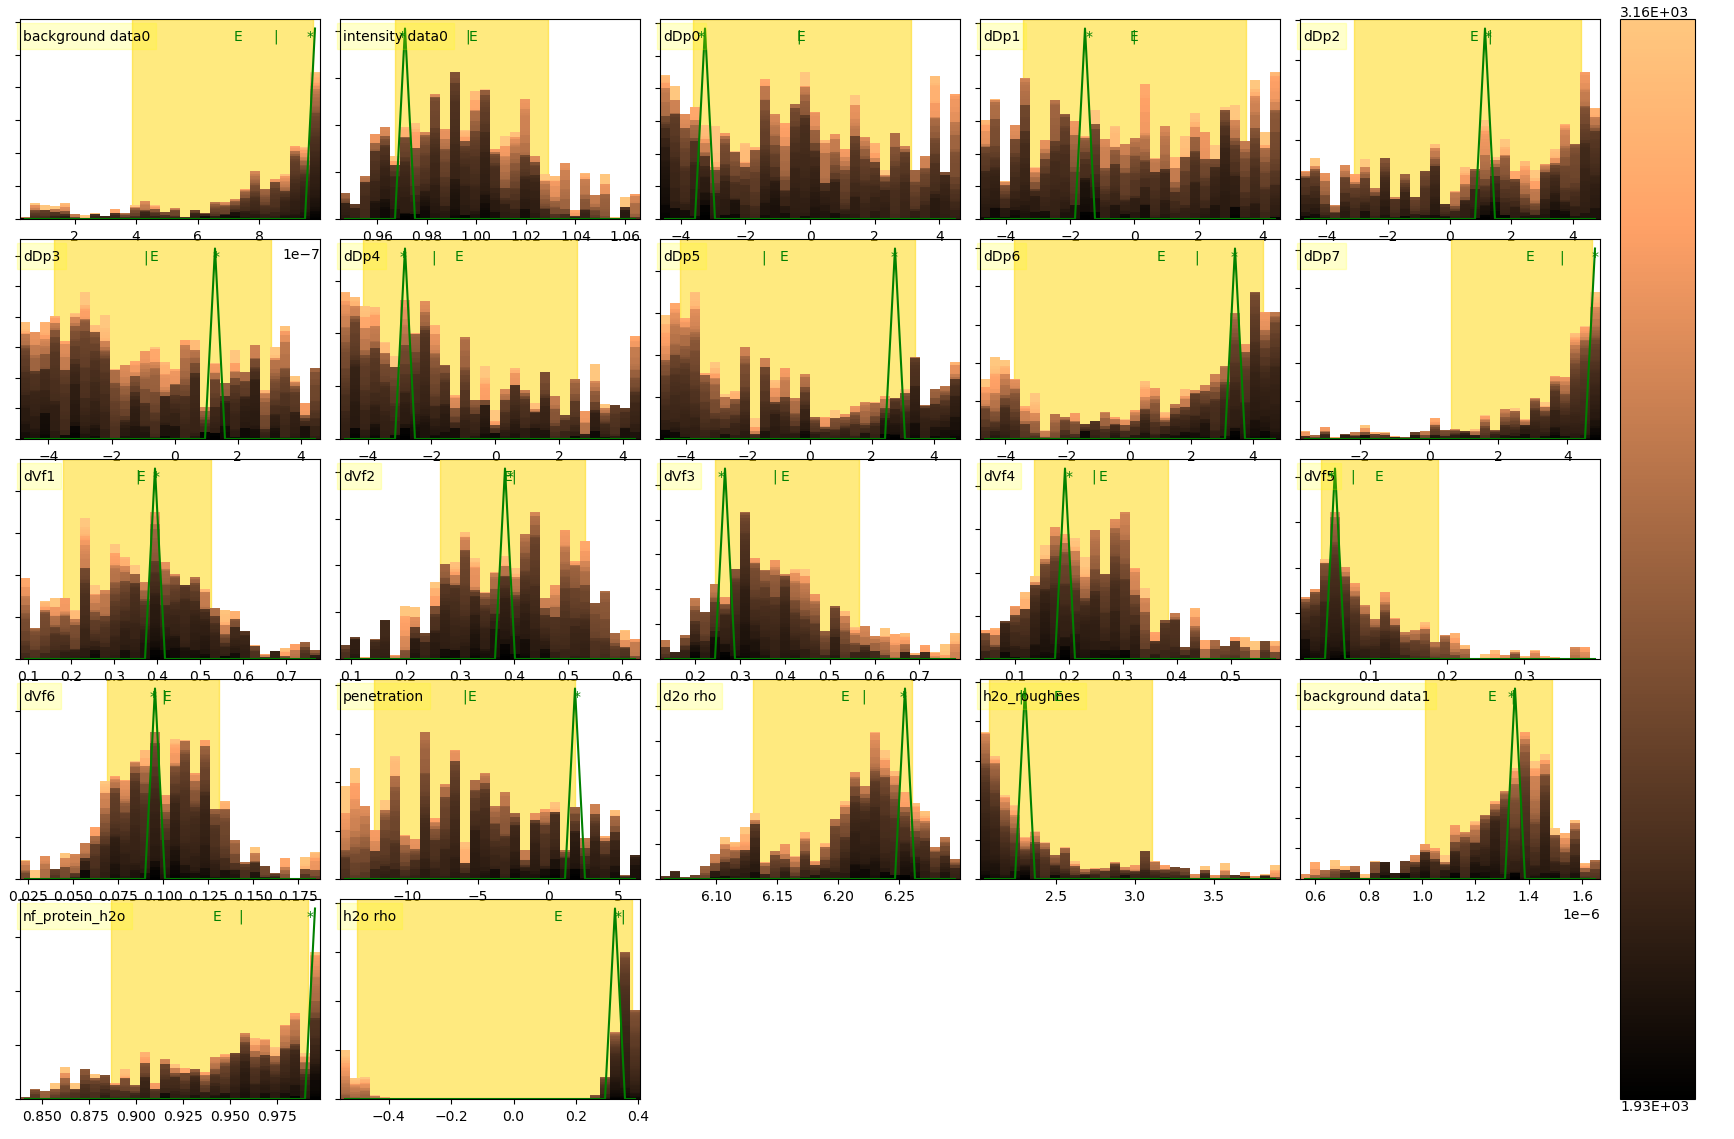

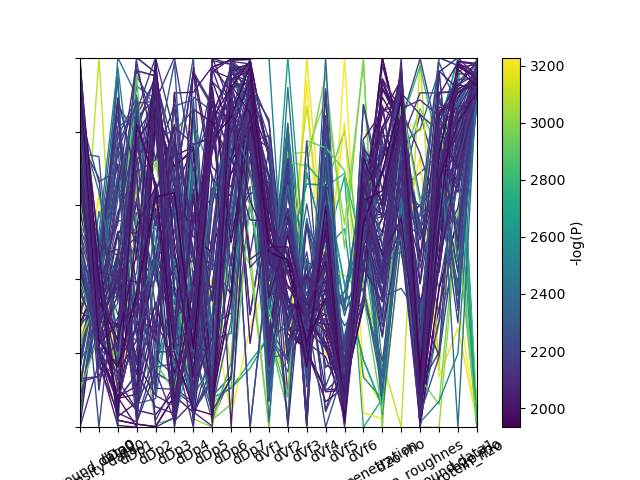

In [9]:
from IPython.display import Image, display
import glob
for file in glob.glob(store+"/*.png"):
    display(Image(filename=file))


# Publication-ready graphs

...

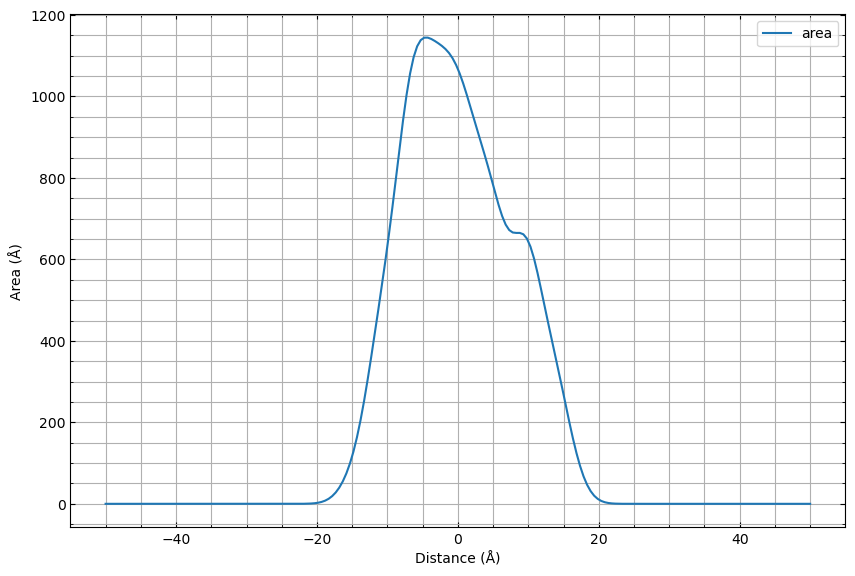

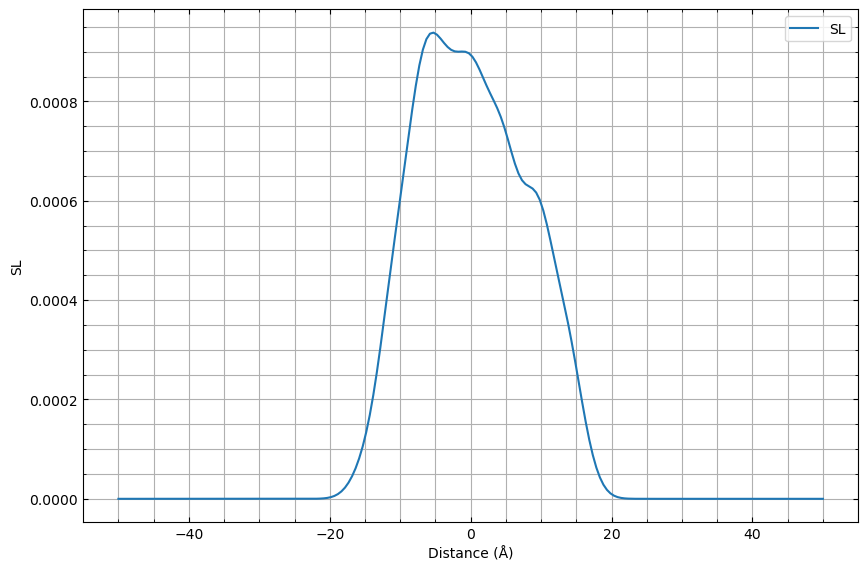